# Ground Station — Data Cleaning & Feature Engineering

In [9]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

## Config

In [10]:
PRQ_IN   = Path("../data_interim/ground_features.parquet")
OUT_INT  = Path("../data_interim")
OUT_PROC = Path("../data_processed")
OUT_INT.mkdir(parents=True, exist_ok=True)
OUT_PROC.mkdir(parents=True, exist_ok=True)

In [11]:
FREQ        = "10min"
LAT, LON, ALT_M = 4.6043, -74.0659, 2624.0
DAY_WM2     = 50.0           # umbral “día” para k
H           = 6              # horizonte +60 min (6*10min)
TARGET_BASE = "ghi_qc"  

## Data

In [12]:
df = pd.read_parquet(PRQ_IN).sort_index()

if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")
else:
    df.index = df.index.tz_convert("UTC")

In [13]:
df.head()

,Hr,p_hpa,wdir_deg,temp_c,wspd_ms,ghi_cs,hod_sin,hod_cos,doy_sin,doy_cos,...,y_ghi_h18,y_ghi_sg_h18,y_k_raw_h24,y_k_h24,y_ghi_h24,y_ghi_sg_h24,y_k_raw_h36,y_k_h36,y_ghi_h36,y_ghi_sg_h36
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-01 05:00:00+00:00,74.391998,745.236023,135.766006,12.505,1.950,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,10371.428711,0.000,0.010371,NaN,3.157978,13.117000,13.100971
2023-09-01 05:10:00+00:00,76.579002,745.085999,112.135002,12.032,2.514,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,29085.714844,0.038,0.029086,NaN,0.846947,21.969999,21.708057
2023-09-01 05:20:00+00:00,75.459999,744.940002,111.295998,12.337,2.126,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,28085.714844,0.031,0.028086,0.477264,0.477013,29.533001,29.517487
2023-09-01 05:30:00+00:00,77.004997,744.969971,102.699997,11.872,2.877,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,-9857.142578,0.000,-0.009857,0.344864,0.355321,36.602001,37.711830
2023-09-01 05:40:00+00:00,77.724998,745.020020,106.753998,11.756,3.159,0.0,0.0,1.0,-0.871706,-0.490029,...,0.0,0.0,NaN,63171.429688,0.000,0.063171,0.285757,0.265680,44.153999,41.051743


In [14]:
print("Date range:", df.index.min(), "→", df.index.max())
print("Columns:", len(df.columns))

Date range: 2023-09-01 05:00:00+00:00 → 2025-03-28 04:50:00+00:00
Columns: 65


## Target

In [15]:
H = 6  # horizonte de +60 min
candidatos = [f"y_ghi_h{H}", f"y_k_h{H}", f"y_ghi_sg_h{H}"]
targets_existentes = [c for c in df.columns if c.startswith("y_")]

TARGET = None
for c in candidatos:
    if c in df.columns:
        TARGET = c
        break
if TARGET is None:
    # como fallback, toma el primer y_*_h{H} que exista
    posibles_h = [c for c in targets_existentes if c.endswith(f"_h{H}")]
    if posibles_h:
        TARGET = posibles_h[0]

if TARGET is None:
    raise RuntimeError(
        f"No encontré ningún target y_* para h={H} en {PRQ_IN}. "
        "Asegúrate de que el parquet master se generó con y_k_h*, y_ghi_h*, y_ghi_sg_h*."
    )

print("Usando TARGET:", TARGET)

Usando TARGET: y_ghi_h6


## Features

In [16]:
# ---- Features = todas las numéricas excepto cualquier y_* (evita fuga) ----
all_numeric = df.select_dtypes(include=[np.number])
y_cols = [c for c in all_numeric.columns if c.startswith("y_")]
FEATS = [c for c in all_numeric.columns if c not in y_cols]  # sin targets


## Selection

In [17]:
Xy = all_numeric[FEATS + [TARGET]].replace([np.inf, -np.inf], np.nan)
Xy = Xy.dropna(subset=[TARGET])         # asegúrate de tener target
Xy = Xy.dropna(how="any")               # si prefieres, aquí puedes ffill/bfill en lugar de drop

In [18]:
const_cols = [c for c in FEATS if Xy[c].nunique(dropna=True) <= 1]
if const_cols:
    Xy = Xy.drop(columns=const_cols)
    FEATS = [c for c in FEATS if c not in const_cols]
    print("Quité columnas constantes:", const_cols)

print(f"Filas tras limpieza: {len(Xy)} | #Features: {len(FEATS)} | Target: {TARGET}")


Filas tras limpieza: 82560 | #Features: 45 | Target: y_ghi_h6


## Split & Export

In [19]:
# %% Split cronológico 70/15/15 (train/val/test)
n = len(Xy)
i1 = int(n*0.70); i2 = int(n*0.85)
train, val, test = Xy.iloc[:i1].copy(), Xy.iloc[i1:i2].copy(), Xy.iloc[i2:].copy()

# %% Export
OUT_ALL = OUT_INT / "ground_features_v2.parquet"
Xy.to_parquet(OUT_ALL, engine="pyarrow", compression="zstd")

# Export splits (útiles para modelado directo)
Xy.to_parquet(OUT_INT / "ground_features_v2.parquet", engine="pyarrow", compression="zstd")
train.to_parquet(OUT_PROC / f"ground_train_h{H}.parquet", engine="pyarrow", compression="zstd")
val.to_parquet  (OUT_PROC / f"ground_val_h{H}.parquet",   engine="pyarrow", compression="zstd")
test.to_parquet (OUT_PROC / f"ground_test_h{H}.parquet",  engine="pyarrow", compression="zstd")

print("Guardado splits para:", TARGET)
print("   train:", train.shape, "val:", val.shape, "test:", test.shape)

Guardado splits para: y_ghi_h6
   train: (57791, 46) val: (12385, 46) test: (12384, 46)


## Sanity

In [20]:
corrs = train[FEATS + [TARGET]].corr(method="spearman", numeric_only=True)[TARGET] \
                              .drop(labels=[TARGET]).sort_values(key=np.abs, ascending=False)
print("\nTop 10 features correlacionadas con", TARGET)
print(corrs.head(10))


Top 10 features correlacionadas con y_ghi_h6
zenith                -0.857557
ghi_cs                 0.857459
ghi_qc_lag1            0.838078
ghi_qc_lag2            0.816877
ghi_qc_roll_mean_1h    0.810178
hod_cos               -0.802457
ghi_qc_lag3            0.795074
ghi_qc_roll_std_1h     0.759086
temp_c                 0.561917
temp_c_lag1            0.532584
Name: y_ghi_h6, dtype: float64


### Visualization

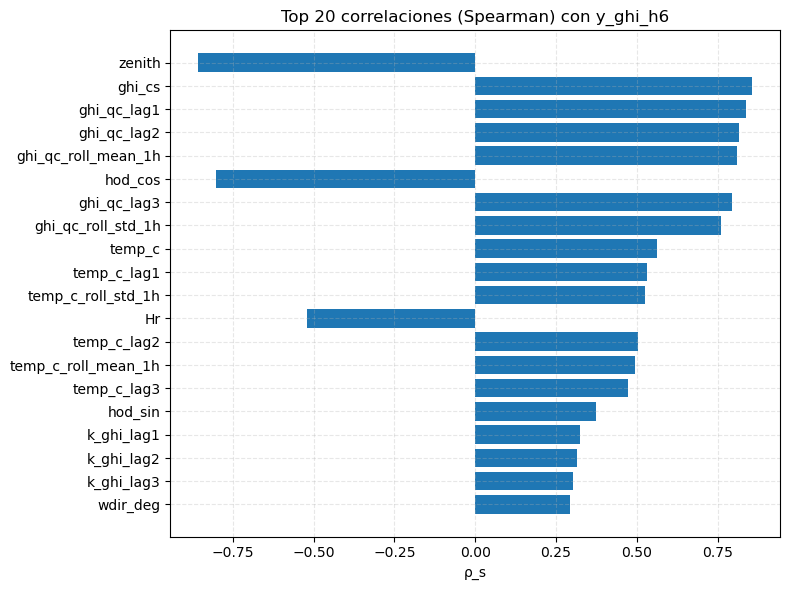

In [21]:
import matplotlib.pyplot as plt
topN = min(20, len(corrs))
plt.figure(figsize=(8, max(4, 0.3*topN)))
plt.barh(corrs.index[:topN][::-1], corrs.values[:topN][::-1])
plt.title(f"Top {topN} correlaciones (Spearman) con {TARGET}")
plt.xlabel("ρ_s"); plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout(); plt.show()